In [ ]:
!pip list

Package                            Version
---------------------------------- --------------------
absl-py                            1.4.0
accelerate                         1.1.1
aiohappyeyeballs                   2.4.3
aiohttp                            3.11.1
aiosignal                          1.3.1
alabaster                          1.0.0
albucore                           0.0.19
albumentations                     1.4.20
altair                             4.2.2
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.5.1
arviz                              0.20.0
astropy                            6.1.6
astropy-iers-data                  0.2024.11.11.0.32.38
astunparse                         1.6.3
async-timeout                      4.0.3
atpublic                           4.1.0
attrs                              24.2.0
audioread         

In [50]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd

**Load Data**

In [51]:
df = pd.read_csv('train.csv')
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [52]:
df[df.columns[2:]].iloc[6]

,6
toxic,1
severe_toxic,1
obscene,1
threat,0
insult,1
identity_hate,0


# Preprocessing

In [53]:
from tensorflow.keras.layers import TextVectorization

In [54]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [55]:
MAX_WORDS = 200000
vectorizer = TextVectorization(max_tokens=MAX_WORDS, output_sequence_length=1800, output_mode='int')

In [56]:
vectorizer.adapt(X.values)

In [57]:
vectorized_text = vectorizer(X.values)

In [58]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

**Create Data Pipeline**



1.   Map
2.   Cache

1.   Shuffle
2.   Batch

1.   Prefetch







In [59]:
data = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
data = data.cache()
data = data.shuffle(160000)
data = data.batch(16)
data = data.prefetch(8)

In [60]:
batch_X, batch_y = data.as_numpy_iterator().next()

In [61]:
batch_X.shape, batch_y.shape

((16, 1800), (16, 6))

In [62]:
train = data.take(int(len(data)*.8))
val = data.skip(int(len(data)*.8)).take(int(len(data)*.1))
test = data.skip(int(len(data)*.9)).take(int(len(data)*.1))

In [63]:
train_gen = train.as_numpy_iterator()
train_gen.next()

(array([[1362,    9, 2562, ...,    0,    0,    0],
        [ 609,   22,    2, ...,    0,    0,    0],
        [ 616,  256,    2, ...,    0,    0,    0],
        ...,
        [   1,    9,   29, ...,    0,    0,    0],
        [1779,    1,  189, ...,    0,    0,    0],
        [ 124,    7,   13, ...,    0,    0,    0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0]]))

# Build Model

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Embedding, Dropout
model = Sequential()
model.add(Embedding(MAX_WORDS+1, 32))
#Birectional wraps LSTM Layer for Bidirectional propogation.
#Tanh is necessary for the required GPU acceleration needed for LSTM by Tensorflow
model.add(Bidirectional(LSTM(32, activation='tanh')))
#Feature Extraction Layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
#Output Layer
model.add(Dense(6, activation='sigmoid'))

In [66]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [70]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 1800, 32)            │       6,400,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 64)                  │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,475,060 (74.29 MB)

 Trainable params: 6,491,686 (24.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,983,374 (49.53 MB)

In [71]:
hist = model.fit(train, epochs=1, validation_data=val)

7979/7979 ━━━━━━━━━━━━━━━━━━━━ 14255s 2s/step - loss: 0.0760 - val_loss: 0.0470


<Figure size 200x200 with 0 Axes>

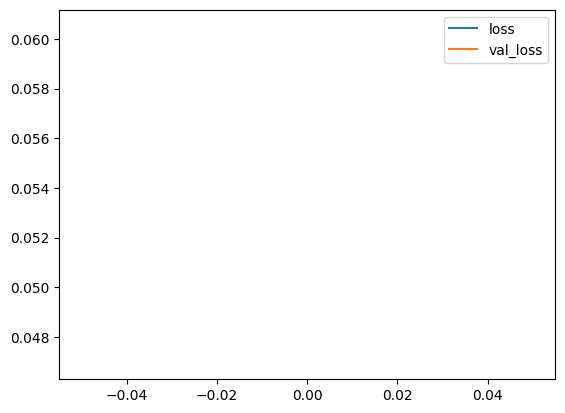

In [73]:
from matplotlib import pyplot as plt
plt.figure(figsize=(2,2))
pd.DataFrame(hist.history).plot()
plt.show()

To See something on the Plot, run the model for atleast 5 Epochs

**Make Predictions**

In [78]:
input_text = vectorizer('You fucking suck you black bastard! Im going to rape you')

In [77]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [80]:
res = model.predict(np.expand_dims(input_text, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


In [81]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [82]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [84]:
batch_y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0]])

In [83]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0]])

# Evaluation

In [85]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [86]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X_true, y_true = batch
    # Make a prediction
    y_pred = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    pre.update_state(y_true, y_pred)
    re.update_state(y_true, y_pred)
    acc.update_state(y_true, y_pred)

**Increase Epochs to increase Accuracy**

In [88]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8724687695503235, Recall:0.59072345495224, Accuracy:0.4714142382144928


# Test and Gradio

In [ ]:
!pip install gradio jinja2

In [90]:
import gradio as gr

In [91]:
model.save('toxicity.h5')

In [92]:
model = tf.keras.models.load_model('toxicity.h5')

In [93]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)

    return text

In [ ]:
interface = gr.Interface(fn=score_comment, inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),outputs='text')

In [ ]:
interface.launch(share=True)